In [1]:
import numpy as np
import pandas as pd

from etl import load_monsters, _mechanics, _stats, _flavor, _skills, get_monster_df

# Load data

In [2]:
monsters, ogl = load_monsters()
monster_df = get_monster_df(monsters)

In [3]:
monster_df[_mechanics].head()

,challenge_rating,armor_class,hit_dice,hit_points,condition_immunities,damage_immunities,damage_resistances,damage_vulnerabilities,actions,reactions,legendary_actions,special_abilities,size,speed,senses
name,,,,,,,,,,,,,,,
Aboleth,10.00,17,18d10,135,,,,,"[{'name': 'Multiattack', 'desc': 'The aboleth ...",[],"[{'name': 'Detect', 'desc': 'The aboleth makes...","[{'name': 'Amphibious', 'desc': 'The aboleth c...",Large,"10 ft., swim 40 ft.","darkvision 120 ft., passive Perception 20"
Acolyte,0.25,10,2d8,9,,,,,"[{'name': 'Club', 'desc': 'Melee Weapon Attack...",[],[],"[{'name': 'Spellcasting', 'desc': 'The acolyte...",Medium,30 ft.,passive Perception 12
Adult Black Dragon,14.00,19,17d12,195,,acid,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],"[{'name': 'Detect', 'desc': 'The dragon makes ...","[{'name': 'Amphibious', 'desc': 'The dragon ca...",Huge,"40 ft., fly 80 ft., swim 40 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Blue Dracolich,17.00,19,18d12,225,"charmed, exhaustion, frightened, paralyzed, po...","lightning, poison",necrotic,,"[{'name': 'Multiattack', 'desc': 'The dracolic...",[],"[{'name': 'Detect', 'desc': 'The dracolich mak...","[{'name': 'Legendary Resistance (3/Day)', 'des...",Huge,"40 ft., burrow 30 ft., fly 80 ft.","blindsight 60 ft., darkvision 120 ft., passive..."
Adult Blue Dragon,16.00,19,18d12,225,,lightning,,,"[{'name': 'Multiattack', 'desc': 'The dragon c...",[],"[{'name': 'Detect', 'desc': 'The dragon makes ...","[{'name': 'Legendary Resistance (3/Day)', 'des...",Huge,"40 ft., burrow 30 ft., fly 80 ft.","blindsight 60 ft., darkvision 120 ft., passive..."


# Feature extraction
At this stage, we'll restrict ourselves to simple feature extraction and engineering. Let's first consider the `actions` column of `monster_df`. We first familiarize ourselves with the data.

In [4]:
actions_keys = {tuple(action.keys()) for actions in monster_df.actions for action in actions}
actions_keys

{('name', 'desc', 'attack_bonus'),
 ('name', 'desc', 'attack_bonus', 'damage_bonus'),
 ('name', 'desc', 'attack_bonus', 'damage_dice'),
 ('name', 'desc', 'attack_bonus', 'damage_dice', 'damage_bonus')}

In [5]:
monster_df.loc['Aboleth'].actions

[{'attack_bonus': 0,
  'desc': 'The aboleth makes three tentacle attacks.',
  'name': 'Multiattack'},
 {'attack_bonus': 9,
  'damage_bonus': 5,
  'damage_dice': '2d6',
  'desc': "Melee Weapon Attack: +9 to hit, reach 10 ft., one target. Hit: 12 (2d6 + 5) bludgeoning damage. If the target is a creature, it must succeed on a DC 14 Constitution saving throw or become diseased. The disease has no effect for 1 minute and can be removed by any magic that cures disease. After 1 minute, the diseased creature's skin becomes translucent and slimy, the creature can't regain hit points unless it is underwater, and the disease can be removed only by heal or another disease-curing spell of 6th level or higher. When the creature is outside a body of water, it takes 6 (1d12) acid damage every 10 minutes unless moisture is applied to the skin before 10 minutes have passed.",
  'name': 'Tentacle'},
 {'attack_bonus': 9,
  'damage_bonus': 5,
  'damage_dice': '3d6',
  'desc': 'Melee Weapon Attack: +9 to hi

In [6]:
monster_df.actions['Rat']

[{'attack_bonus': 0,
  'damage_bonus': 1,
  'desc': 'Melee Weapon Attack: +0 to hit, reach 5 ft., one target. Hit: 1 piercing damage.',
  'name': 'Bite'}]

In [7]:
from collections import namedtuple
from functools import partial, reduce
import re


get_dc = partial(re.findall,
                 re.compile(r'\bDC (\d+) (' \
                            + r'|'.join(stat.capitalize() for stat in _stats) \
                            + r')\b'))

get_dice = partial(re.findall, re.compile(r'\b(\d+)?d(\d+)\b'))



In [8]:
# summary tools
def has_properties(x, pos=[], neg=[]):
    return any(all([z in y for z in pos] + [z not in y for z in neg]) for y in x)


def parse_actions(actions):
    multi = False
    for action in actions:
        if action['name'] == 'Multiattack':
            multi = True
            continue
        attack_bonus = action.get('attack_bonus', 0)
        damage_bonus = action.get('damage_bonus', 0)
        damage_dice = action.get('damage_dice', '')
        dcs = get_dc(action.get('desc'))
    return multi, attack_bonus, damage_bonus, damage_dice, dcs
neg=['damage_dice', 'damage_bonus']
def has_special_action(actions):
    return any(is_special_action(action) for action in actions)

def is_special_action(action):
    return 'Multiattack' not in action['name'] and all([z not in action for z in neg])

def get_special_action(actions):
    return [action for action in actions if is_special_action(action)]

monster_df.actions[monster_df.actions.apply(has_special_action)].apply(get_special_action).head()

name
Aboleth                 [{'name': 'Enslave (3/day)', 'desc': 'The abol...
Adult Black Dragon      [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Blue Dracolich    [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Blue Dragon       [{'name': 'Frightful Presence', 'desc': 'Each ...
Adult Brass Dragon      [{'name': 'Frightful Presence', 'desc': 'Each ...
Name: actions, dtype: object

In [9]:
monster_df.loc['Wereboar'].actions

[{'attack_bonus': 0,
  'desc': 'The wereboar makes two attacks, only one of which can be with its tusks.',
  'name': 'Multiattack (Humanoid or Hybrid Form Only)'},
 {'attack_bonus': 5,
  'damage_bonus': 3,
  'damage_dice': '2d6',
  'desc': 'Melee Weapon Attack: +5 to hit, reach 5 ft., one target. Hit: 10 (2d6 + 3) bludgeoning damage.',
  'name': 'Maul (Humanoid or Hybrid Form Only)'},
 {'attack_bonus': 5,
  'damage_bonus': 3,
  'damage_dice': '2d6',
  'desc': 'Melee Weapon Attack: +5 to hit, reach 5 ft., one target. Hit: 10 (2d6 + 3) slashing damage. If the target is a humanoid, it must succeed on a DC 12 Constitution saving throw or be cursed with wereboar lycanthropy.',
  'name': 'Tusks (Boar or Hybrid Form Only)'}]

In [10]:
f = partial(has_properties, pos=['damage_bonus'], neg=['damage_dice'])

monster_df.actions[monster_df.actions.apply(f)]

name
Badger             [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Bat                [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Cat                [{'name': 'Claws', 'desc': 'Melee Weapon Attac...
Crab               [{'name': 'Claw', 'desc': 'Melee Weapon Attack...
Flying Snake       [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Hawk               [{'name': 'Talons', 'desc': 'Melee Weapon Atta...
Homunculus         [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Lizard             [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Octopus            [{'name': 'Tentacles', 'desc': 'Melee Weapon A...
Owl                [{'name': 'Talons', 'desc': 'Melee Weapon Atta...
Poisonous Snake    [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Quipper            [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Rat                [{'name': 'Bite', 'desc': 'Melee Weapon Attack...
Scorpion           [{'name': 'Sting', 'desc': 'Melee Weapon Attac...
Spider             [{'name': 

In [11]:
get_dc(monster_df.actions[0][3]['desc'])

[('14', 'Wisdom')]

## Actions

In [12]:
from collections import namedtuple
Summary = namedtuple('Summary', field_names='has_multiattack attack_bonus damage difficulty_class')

def summarize_actions(actions):
    has_multiattack = 1 if any('Multiattack' in action['name'] for action in actions) else 0
    action_summaries = [summarize(action) for action in actions]
    if action_summaries:
        max_attack_bonus = max(action['attack_bonus'] for action in action_summaries)
        max_damage = max(action['damage'] for action in action_summaries)
        max_difficulty_class = max(action['difficulty_class'] for action in action_summaries)
        summary = Summary(has_multiattack=has_multiattack, 
                          attack_bonus=max_attack_bonus, 
                          damage=max_damage, 
                          difficulty_class=max_difficulty_class)
    else:
        summary = Summary(has_multiattack=0,
                          attack_bonus=2,
                          damage=1,
                          difficulty_class=10)
    return summary


def summarize(action):
    difficulty_class = get_dc(action['desc'])
    attack_bonus = int(action.get('attack_bonus', '0'))
    damage_dice = action.get('damage_dice', '0d0')
    damage_bonus = int(action.get('damage_bonus', '0'))
    return {'attack_bonus': attack_bonus,
            'damage': get_damage_potential(damage_dice, damage_bonus),
            'difficulty_class': get_max_dc(difficulty_class)}

def get_damage_potential(damage_dice, damage_bonus):
    damage = damage_bonus
    for roll in damage_dice.split(' + '):
        n, size = get_dice(roll)[0]
        damage += int(n) * int(size)
    return damage

def get_max_dc(difficulty_class):
    if difficulty_class:
        return max([int(x[0]) for x in difficulty_class if x])
    else:
        return 10

In [13]:
attacks = monster_df.actions.apply(summarize_actions)

In [14]:
attacks_df = pd.concat([attacks.map(lambda x: x[i]) for i in range(4)], axis=1)
attacks_df.columns = 'has_multiattack attack_bonus damage difficulty_class'.split(' ')

# quick linear model

In [15]:
X = pd.concat([monster_df[['armor_class', 'hit_points']], attacks_df], axis=1)

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
y = monster_df.challenge_rating

lr.fit(X, y)

pred = pd.DataFrame(y)
pred['cr_hat'] = lr.predict(X)

/Users/jason/Code/cr/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


/Users/jason/Code/cr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


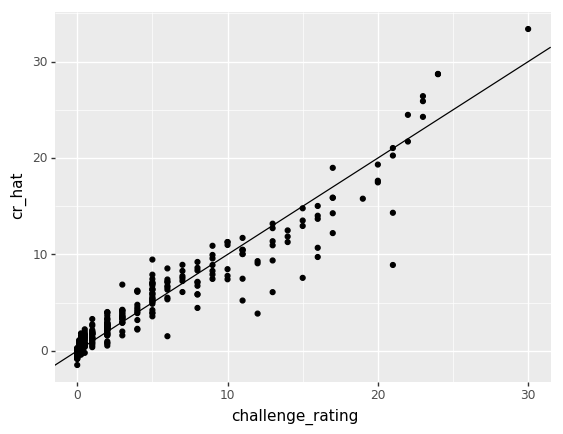

<ggplot: (285150461)>

In [17]:
from plotnine import (aes, geom_abline, geom_point, ggplot)
ggplot(pred, aes(x='challenge_rating', y='cr_hat')) + geom_point() + geom_abline(intercept = 0, slope = 1)

In [18]:
lr.score(X, y)

0.91243233372362997

## Special abilities

In [19]:
special_keys = {tuple(ability.keys()) for abilities in monster_df.special_abilities for ability in abilities}
special_keys

{('name', 'desc', 'attack_bonus'),
 ('name', 'desc', 'attack_bonus', 'damage_dice')}

In [20]:
from collections import Counter

from functools import reduce
name_lists = monster_df.special_abilities.apply(lambda x: [y['name'] for y in x])
abilities = Counter(reduce(lambda x, y: x + y, name_lists, []))
abilities.most_common(15)

[('Magic Resistance', 32),
 ('Amphibious', 30),
 ('Legendary Resistance (3/Day)', 24),
 ('Innate Spellcasting', 20),
 ('Keen Smell', 19),
 ('Pack Tactics', 16),
 ('False Appearance', 15),
 ('Spider Climb', 13),
 ('Keen Hearing and Smell', 13),
 ('Spellcasting', 12),
 ('Magic Weapons', 12),
 ('Charge', 12),
 ('Shapechanger', 11),
 ('Swarm', 10),
 ('Water Breathing', 9)]

In [51]:
special_abilities = reduce(lambda x, y: x + y, monster_df.special_abilities, [])
spell_casting = [ability for ability in special_abilities if 'Spellcasting' == ability['name']]
innate_spell_casting = [ability for ability in special_abilities if 'Innate Spellcasting' == ability['name']]

In [60]:
for ability in innate_spell_casting:
    print (ability['desc'])
    print ('\n\n')

The giant's innate spellcasting ability is Charisma. It can innately cast the following spells, requiring no material components:

At will: detect magic, fog cloud, light
3/day each: feather fall, fly, misty step, telekinesis
1/day each: control weather, gaseous form



The couatl's spellcasting ability is Charisma (spell save DC 14). It can innately cast the following spells, requiring only verbal components:

At will: detect evil and good, detect magic, detect thoughts
3/day each: bless, create food and water, cure wounds, lesser restoration, protection from poison, sanctuary, shield
1/day each: dream, greater restoration, scrying



The gnome's innate spellcasting ability is Intelligence (spell save DC 11). It can innately cast the following spells, requiring no material components:
At will: nondetection (self only)
1/day each: blindness/deafness, blur, disguise self



The deva's spellcasting ability is Charisma (spell save DC 17). The deva can innately cast the following spells, r

In [56]:
def parse_spellcasting(special_ability):
    desc = special_ability['desc']
    header, *levels = desc.splitlines()
    return header, levels

In [67]:
for header, levels in map(parse_spellcasting, spell_casting_examples):
    print(header)
    for i, level in enumerate(levels):
        print ('{}: {}'.format(i, level))
    print('\n')

The acolyte is a 1st-level spellcaster. Its spellcasting ability is Wisdom (spell save DC 12, +4 to hit with spell attacks). The acolyte has following cleric spells prepared:
0: 
1: • Cantrips (at will): light, sacred flame, thaumaturgy
2: • 1st level (3 slots): bless, cure wounds, sanctuary


The sphinx is a 12th-level spellcaster. Its spellcasting ability is Wisdom (spell save DC 18, +10 to hit with spell attacks). It requires no material components to cast its spells. The sphinx has the following cleric spells prepared:
0: 
1: • Cantrips (at will): sacred flame, spare the dying, thaumaturgy
2: • 1st level (4 slots): command, detect evil and good, detect magic
3: • 2nd level (3 slots): lesser restoration, zone of truth
4: • 3rd level (3 slots): dispel magic, tongues
5: • 4th level (3 slots): banishment, freedom of movement
6: • 5th level (2 slots): flame strike, greater restoration
7: • 6th level (1 slot): heroes' feast


The archmage is an 18th-level spellcaster. Its spellcasting ab

## Special defenses
We now apply a bit of domain knowledge to separate out the following features.

In [23]:
from functools import partial, reduce

def string_to_list(x, sep=','):
    return [y.strip() for y in x.split(sep)]


def concat(lists):
    return reduce(lambda x, y: x + y, lists, [])


def get_unique_values(series, sep=','):
    lists = series.apply(partial(string_to_list, sep=sep))
    values = concat(lists)
    return sorted(v for v in set(values) if v)

In [24]:
condition_immunities = get_unique_values(monster_df.condition_immunities)
damage_immunities = get_unique_values(monster_df.damage_immunities, sep=';')
damage_resistances = get_unique_values(monster_df.damage_resistances, sep=';')
damage_vulnerabilities = get_unique_values(monster_df.damage_vulnerabilities)

In [25]:
damage_vulnerabilities

['bludgeoning',
 'cold',
 'fire',
 'piercing from magic weapons wielded by good creatures',
 'radiant',
 'thunder']

In [27]:
CONDITIONS = ['blinded',
              'charmed',
              'deafened',
              'exhaustion',
              'fatigued',
              'frightened',
              'grappled',
              'incapacitated',
              'invisible',
              'paralyzed',
              'petrified',
              'poisoned',
              'prone',
              'restrained',
              'stunned',
              'unconscious']

## Reactions

In [66]:
reactions = monster_df.reactions[monster_df['reactions'].apply(lambda x: len(x) > 0)]
for reaction in reactions: 
    for k, v in reaction[0].items():
        print("{}: {}".format(k, v))
    print('\n')

name: Parry
desc: The captain adds 2 to its AC against one melee attack that would hit it. To do so, the captain must see the attacker and be wielding a melee weapon.
attack_bonus: 0


name: Split
desc: When a pudding that is Medium or larger is subjected to lightning or slashing damage, it splits into two new puddings if it has at least 10 hit points. Each new pudding has hit points equal to half the original pudding's, rounded down. New puddings are one size smaller than the original pudding.
attack_bonus: 0


name: Unnerving Mask
desc: When a creature the devil can see starts its turn within 30 feet of the devil, the devil can create the illusion that it looks like one of the creature's departed loved ones or bitter enemies. If the creature can see the devil, it must succeed on a DC 14 Wisdom saving throw or be frightened until the end of its turn.
attack_bonus: 0


name: Parry
desc: The erinyes adds 4 to its AC against one melee attack that would hit it. To do so, the erinyes must 